In [1]:
#импортируем разное
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import matplotlib.pyplot as plt

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


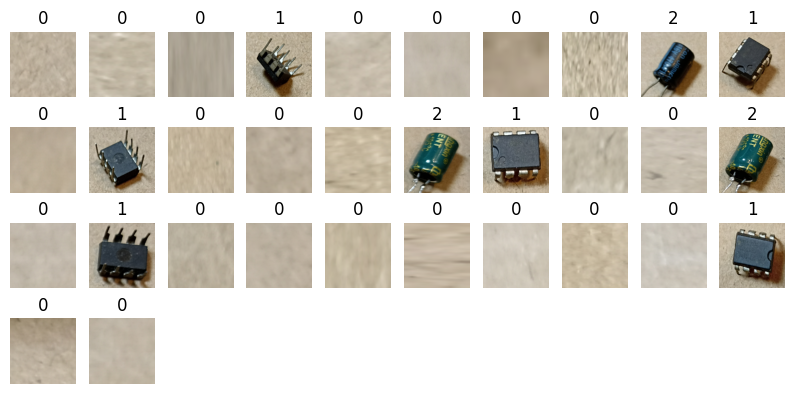

In [2]:
#прочитаем запись
dataset = tf.data.TFRecordDataset('classifier_dataset.tfrecord')


def parse_record(record):
    #нужно описать приходящий экземпляр
    #имена элементов как при записи
    feature_description = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'name': tf.io.FixedLenFeature([], tf.string)
    }
    parsed_record = tf.io.parse_single_example(record, feature_description)
    img = tf.io.parse_tensor(parsed_record['img'], out_type=tf.float32)
    name = tf.io.parse_tensor(parsed_record['name'], out_type=tf.int32)
    return img, name

#пройдемся по записи и распакуем ее
dataset = dataset.map(parse_record)

#еще раз проверим


dataset = dataset.shuffle(50).cache().prefetch(buffer_size=tf.data.AUTOTUNE).batch(64).shuffle(50)

for i, n in dataset.take(1):
    plt.figure(figsize=(10, 6))
    i = i.numpy()
    n = n.numpy()
    for nn in range(32):
        
        ax = plt.subplot(5, 10, 1 + nn)
        
        plt.title(n[nn])
        plt.imshow(i[nn])
        plt.axis('off')
    plt.show()

In [3]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',
                                               include_top=False,
                                               input_shape=(128,128, 3))
base_model.trainable = False

In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Input, Conv2D, GlobalAveragePooling2D, Dropout

#давайте напишем нейросеть

inputs = Input((128,128,3))
x = base_model(inputs)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(3, activation = 'softmax')(x)

outputs = x

classifier = keras.Model(inputs, outputs)


In [5]:
class Model(tf.keras.Model):
    def __init__(self, nn):
        super(Model, self).__init__()
        self.nn = nn
        self.optimizer = tf.keras.optimizers.Adam(1e-3)
        
    def get_loss(self, y, preds):
        loss = tf.keras.losses.CategoricalCrossentropy()(tf.one_hot(y, 3),preds)
        return loss
        
    @tf.function
    def training_step(self, x , y):
        with tf.GradientTape() as tape:
            
            preds = self.nn(x)
            loss = self.get_loss(y, preds)
            
        gradients = tape.gradient(loss, self.nn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return tf.reduce_mean(loss)   
    
model = Model(classifier)

In [6]:
for i, c in dataset.take(1):
    print(tf.reduce_mean(model.training_step(i, c)))

tf.Tensor(0.87245464, shape=(), dtype=float32)


10


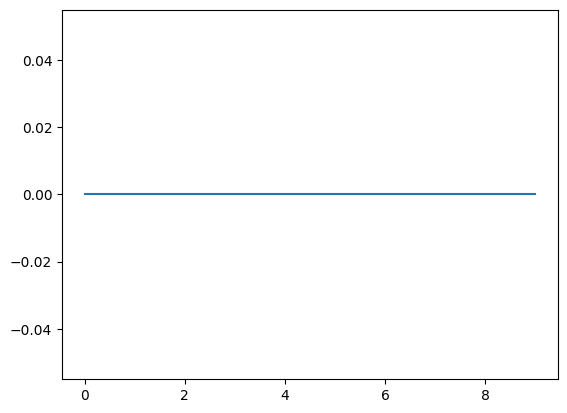

In [8]:
from IPython.display import clear_output
hist = np.array(np.empty([0]))
epochs = 10

for epoch in range(1, epochs + 1):
    loss = 0
    lc = 0
    for step, (i, n) in enumerate(dataset):
        loss+=tf.reduce_mean(model.training_step(i,n))
        lc+=1
    clear_output(wait=True)
    print(epoch)
    hist = np.append(hist, loss/lc)
    plt.plot(np.arange(0,len(hist)), hist)
    plt.show()

[1. 0. 0.]
[1. 0. 0.]
[0. 1. 0.]
[1. 0. 0.]
[0.0000000e+00 4.4725703e-37 1.0000000e+00]


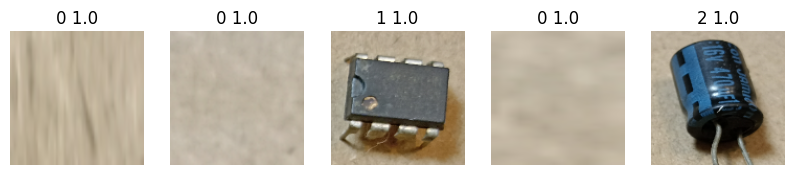

In [12]:
def imshow_and_pred():    
    n = 5
    plt.figure(figsize=(10, 6))
    for images, labels in dataset.take(1):
        preds = model.nn(images)
        for i in range(n):
            img = images[i]
            
            
            pred = preds[i].numpy()
            print(pred)
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img, cmap='gist_gray')
            
            ma = pred.max()
            res = np.where(pred == ma)
            
            plt.title(str(res[0][0]) +' '+ str(round(pred[res[0][0]], 3)))
            plt.axis('off')
            ax.get_yaxis().set_visible(False)           
    plt.show()
imshow_and_pred()

In [13]:
model.nn.save('my_classifier.h5')